In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import gcf
import numpy as np 
from einops import rearrange
from sklearn import cluster

In [8]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition._nmf import NMF
import math
import seaborn as sns
from matplotlib.patches import Rectangle

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
from mcmodels.models.voxel.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique 
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3,get_indices_2ormore#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')

annotation/ccf_2017


In [4]:
#load data
def cv_nmf_missing(data, n_components,alpha=0.01, l1_ratio = 1.,p_holdout = .3):
    
    missings = np.asarray(np.where(np.isnan(data))).transpose()
    presents = np.asarray(np.where(~np.isnan(data))).transpose()

    M = np.where(np.random.rand(presents.shape[0]) > p_holdout)[0]
    N = np.where(np.random.rand(presents.shape[0]) < p_holdout)[0]

    nmf = NMF(n_components=n_components, alpha=alpha, l1_ratio=l1_ratio, solver='mu', init = 'random', max_iter=500)

    data_tr = data.copy()
    for i in range(len(M)):
        data_tr[presents[M[i],0] ,presents[M[i],1]]  =np.nan

    data_te = data.copy()
    for i in range(len(N)):
        data_te[presents[N[i],0] ,presents[N[i],1]]  =np.nan

    nmf.fit(data_tr)

    tr_nmf_embedding = nmf.transform(data_tr)
    te_nmf_embedding = nmf.transform(data_te)

    tr_nmf_recon = nmf.inverse_transform(tr_nmf_embedding)
    te_nmf_recon = nmf.inverse_transform(te_nmf_embedding)
    tr_err = np.nanmean((data_tr - tr_nmf_recon)**2)
    te_err= np.nanmean((data_te - te_nmf_recon)**2)
    
    return(tr_err, te_err)

def fix_pdcsv(csv):
    
    csv_rownames = np.asarray(csv.iloc[:,0])
    csv = csv.iloc[:,1:]
    csv.index = csv_rownames
    return(csv)

def fill_df_na(data, indices):
    
    for i in range(indices.shape[0]):
        data.iloc[indices[i,0],indices[i,1]] = np.nan
        
    return(data)

def get_colors(structures, palettes, alpha):
    
    strs_unique = np.unique(structures)
    nstr = len(strs_unique)
    cs = sns.color_palette("Spectral", nstr)
    
    #print(np.asarray(cs).shape, np.expand_dims(np.ones(12),1).shape)
    cs_alphas = np.hstack([np.asarray(cs), alpha*np.expand_dims(np.ones(12),1)])
    color_str = {}
    for i in range(nstr):
        #print(i)
        color_str[strs_unique[i]] = cs_alphas[i]
    #print(color_str['CB'])
    #print(color_str)
    output = np.zeros((len(structures),4), dtype  =float)
    for i in range(len(structures)):
        #print(np.asarray(color_str[structures[i]]))
        output[i] = np.asarray(color_str[structures[i]])
        
    return(output,color_str)

wt_conn = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/connectivities/ELLeafsmoothsummarysurface_leafsource_summarytarget_v3/elsummarymodel_leafsource_summarytarget_wt_v3.csv',  header=[0,1])
wt_conn = fix_pdcsv(wt_conn)
dists = pd.read_csv('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/distances.csv',  header=[0,1])
dists = fix_pdcsv(dists)
wt_conn = wt_conn.loc[dists.index]
wt_conn = wt_conn.loc[:,dists.columns]

In [5]:
dists.iloc[101,43]

79.2569675620158

In [6]:
#get ontological order structures and leaf major regions
oos_ic_majors = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/oos_ic_majors_v3.npy')
ool_ic_majors = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/ool_majors_names_v3.npy')

ccol,ccol_dict = get_colors(np.asarray(oos_ic_majors), sns.color_palette("Spectral", 12), 1.)
crow,crow_dict = get_colors(np.asarray(ool_ic_majors), sns.color_palette("Spectral", 12), 1.)
reo = np.asarray([4,7,2,1,10,9,11,3,5,8,6,0])
low_values = np.asarray(np.where(dists < 15)).transpose()

In [7]:
data = np.asarray(fill_df_na(wt_conn, low_values))
rss= np.nansum(data, axis = 1)
ids = np.where(rss > 0.)[0]

In [26]:
np.where(data[ids] >= 1e-5)[0].shape

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


(68130,)

In [27]:
np.where(data[ids] < 1e-5)[0].shape

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


(45125,)

In [57]:
wt_conn_min = np.asarray(wt_conn.copy())
wt_conn_min[np.where(wt_conn < 1e-5)] = 1e-5
wt_conn_min_log = np.log10(wt_conn_min)

In [152]:
help(LinearRegression)

Help on class LinearRegression in module sklearn.linear_model._base:

class LinearRegression(sklearn.base.MultiOutputMixin, sklearn.base.RegressorMixin, LinearModel)
 |  LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
 |  
 |  Ordinary least squares Linear Regression.
 |  
 |  LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
 |  to minimize the residual sum of squares between the observed targets in
 |  the dataset, and the targets predicted by the linear approximation.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : bool, optional, default True
 |      Whether to calculate the intercept for this model. If set
 |      to False, no intercept will be used in calculations
 |      (i.e. data is expected to be centered).
 |  
 |  normalize : bool, optional, default False
 |      This parameter is ignored when ``fit_intercept`` is set to False.
 |      If True, the regressors X will be normalized before regression by
 |      subt

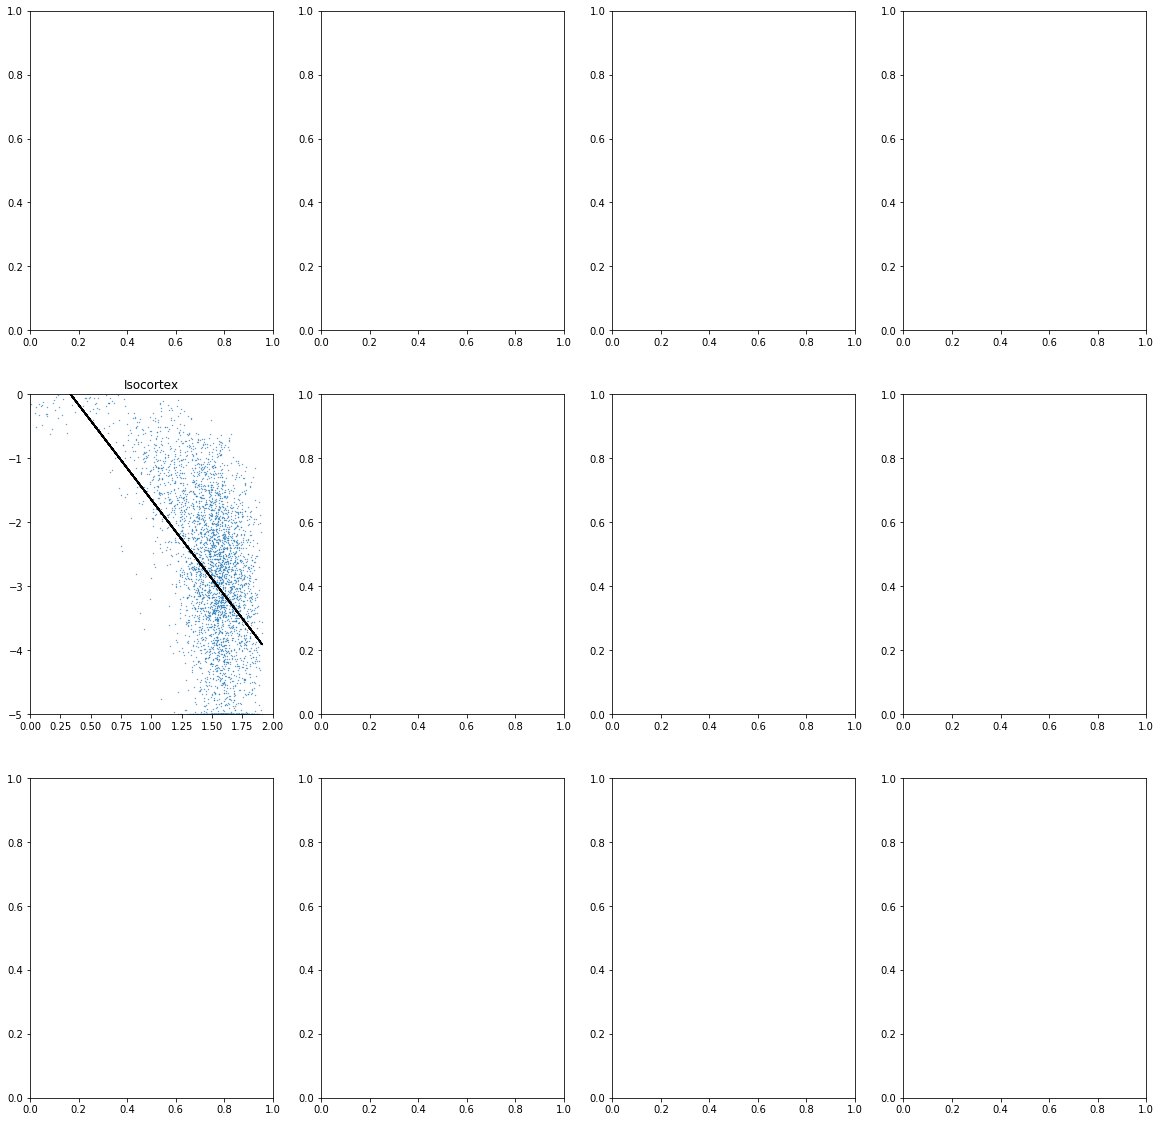

In [158]:
fig, axes = plt.subplots(3,4,figsize = (20,20))
for m in range(4,5):
    inds = np.where(ool_ic_majors[ids] == major_structures[m])[0]
    inds2 = np.where(oos_ic_majors[ids] == major_structures[m])[0]
    xs = np.log10(np.asarray(dists)[ids][inds][:,np.intersect1d(list(range(321)), inds2)])
    ys = wt_conn_min_log[ids][inds][:,inds2]
    xs = np.reshape(xs, xs.shape[0]*xs.shape[1])
    ys = np.reshape(ys, ys.shape[0]*ys.shape[1])
    kepinds = np.where(np.isinf(xs))[0]
    #print(kepinds)
    xs = xs[np.setdiff1d(list(range(len(xs))),kepinds)]
    ys = ys[np.setdiff1d(list(range(len(ys))),kepinds)]
    lr = LinearRegression()
    lr.fit(np.expand_dims(xs,1),ys)
    axes[math.floor(m / 4), m%4].scatter(xs,ys, s = .1)
    yp = lr.intercept_ + np.expand_dims(xs,1) * lr.coef_
    axes[math.floor(m / 4), m%4].plot(xs, yp,color='k')
    axes[math.floor(m / 4), m%4].set_title(major_structures[m])
    axes[math.floor(m / 4), m%4].set_xlim(0,2)
    axes[math.floor(m / 4), m%4].set_ylim(-5,0)

array([   0,   38,  115,  153,  191,  230,  268,  306,  383,  421,  459,
        498,  536,  574,  612,  651,  689,  727,  765,  804,  842,  880,
        918,  957,  995, 1033, 1072, 1112, 1150, 1188, 1228, 1266, 1305,
       1343, 1381, 1419, 1458, 1496, 1534, 1573, 1611, 1650, 1689, 1727,
       1765, 1804, 1842, 1880, 1918, 1957, 1961, 1995, 1999, 2033, 2037,
       2071, 2110, 2148, 2186, 2224, 2301, 2339, 2378, 2416, 2454, 2489,
       2493, 2527, 2531, 2569, 2608, 2646, 2684, 2723, 2761, 2799, 2838,
       2876, 2914, 2953, 2991])

In [164]:
#lr.fit(np.expand_dims(xs,1)[np.where(np.expand_dims(xs,1) < .7)[0]],ys[np.where(np.expand_dims(xs,1) < .7)[0]])

In [163]:
#lr.coef_

In [159]:
lr.coef_

array([-2.47559217])

In [34]:
from sklearn.linear_model import LinearRegression

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/samsonkoelle/anaco

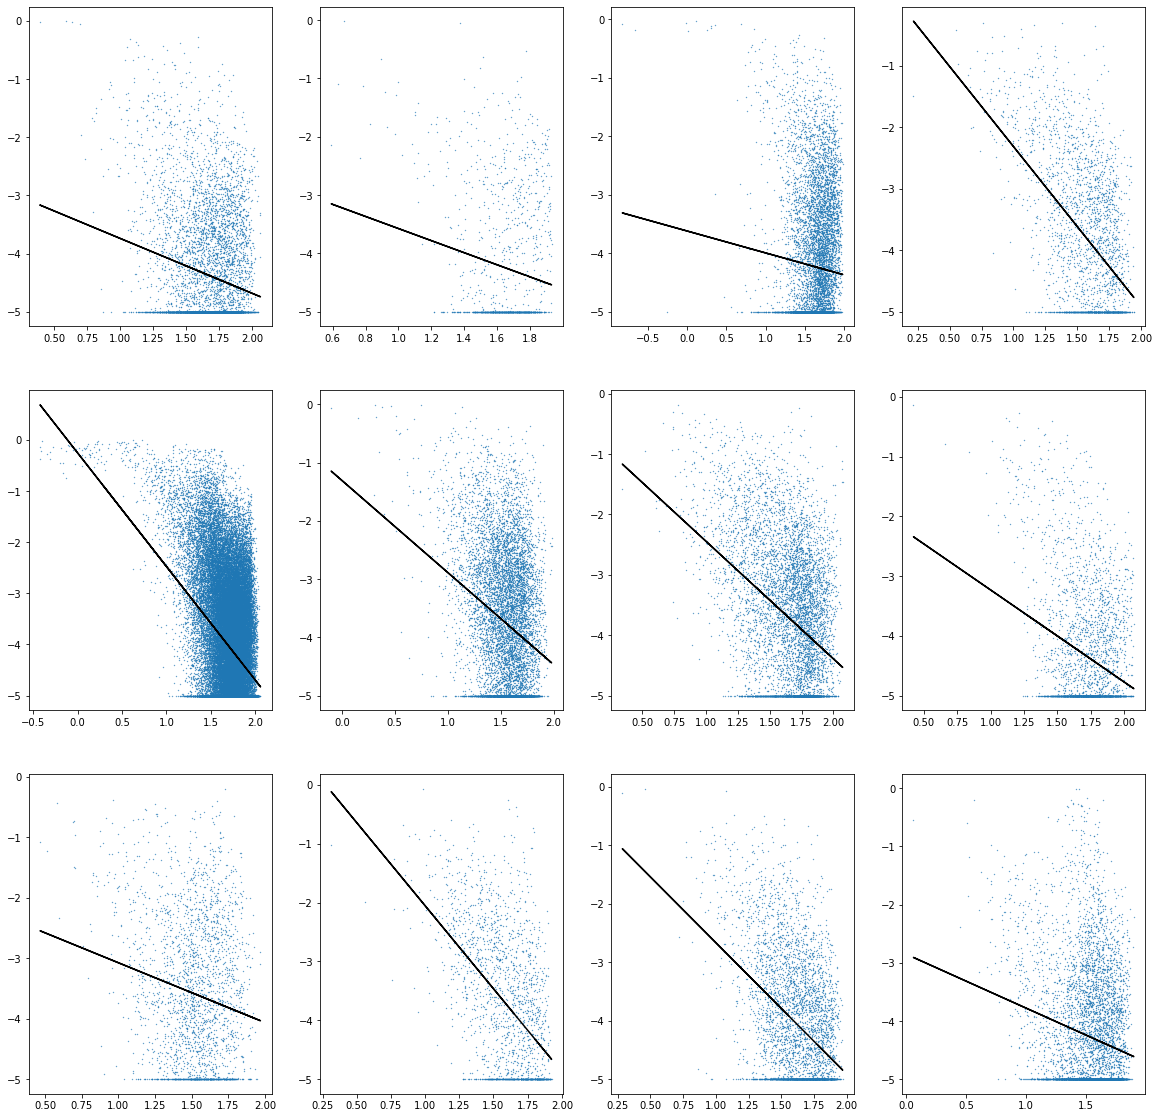

In [150]:
fig, axes = plt.subplots(3,4,figsize = (20,20))
for m in range(12):
    inds = np.where(ool_ic_majors[ids] == major_structures[m])[0]
    xs = np.log10(np.asarray(dists)[ids][inds])
    ys = wt_conn_min_log[ids][inds]
    xs = np.reshape(xs, xs.shape[0]*xs.shape[1])
    ys = np.reshape(ys, ys.shape[0]*ys.shape[1])
    kepinds = np.where(np.isinf(xs))[0]
    #print(kepinds)
    xs = xs[np.setdiff1d(list(range(len(xs))),kepinds)]
    ys = ys[np.setdiff1d(list(range(len(ys))),kepinds)]
    lr = LinearRegression()
    lr.fit(np.expand_dims(xs,1),ys)
    axes[math.floor(m / 4), m%4].scatter(xs,ys, s = .1)
    yp = lr.intercept_ + np.expand_dims(xs,1) * lr.coef_
    axes[math.floor(m / 4), m%4].plot(xs, yp,color='k')

In [145]:
    lr = LinearRegression()
    lr.fit(np.expand_dims(xs,1),ys)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

array([[-4.61682627],
       [-4.52193821],
       [-4.55409383],
       ...,
       [-4.274574  ],
       [-4.34480888],
       [-4.19406421]])

In [143]:
lr.predict(0)

TypeError: check_is_fitted() missing 1 required positional argument: 'attributes'

In [141]:
lr.predict(np.expand_dims(xs,1))

TypeError: check_is_fitted() missing 1 required positional argument: 'attributes'

In [135]:
lr.intercept_

-2.8481244671777386

In [136]:
lr.coeff

AttributeError: 'LinearRegression' object has no attribute 'coeff'

In [ ]:
lr.

In [124]:
np.where(np.isinf(xs))

(array([0, 1, 2, 3, 4, 5, 6]),)

In [125]:
xs

array([-inf, -inf, -inf, -inf, -inf, -inf, -inf])

In [119]:
dists.index[ids[101]]

'MOB'

In [121]:
#np.where(dists == 0)

In [105]:
dists.columns[43]

('ipsi', 'MOB')

In [99]:
divmod(np.asarray(dists)[ids].argmin(), np.asarray(dists)[ids].shape[1])

(101, 43)

In [101]:
np.asarray(dists)[ids][101,43]

0.0

In [106]:
mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}


In [108]:
ai_map['VISal4']

1114

In [109]:
ai_map['MOB']

507

In [110]:
from mcmodels.core import Mask
def get_regional_centroids(cache,sid,hemisphere_id):
    
    mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=hemisphere_id)
    centroid_loc = np.mean(mask.coordinates, axis = 0)
    
    return(centroid_loc)

In [114]:
np.linalg.norm(get_regional_centroids(cache,1114,2) - get_regional_centroids(cache,507,2))

79.2569675620158

array([13.67940889, 43.92037128, 65.64741085])

In [ ]:
regional_centroids_ipsitargets = np.asarray([get_regional_centroids(cache,ai_map[ipsi_names[i]],hemisphere_id = 2) for i in range(len(ipsi_inds))])
regional_centroids_contratargets = np.asarray([get_regional_centroids(cache,ai_map[contra_names[i]],hemisphere_id = 1) for i in range(len(contra_inds))])


regional_centroids_targets = np.vstack([regional_centroids_ipsitargets,regional_centroids_contratargets])

ntarg = wt_conn_oo.shape[1]
nsource = regional_centroids_sources.shape[0]
distances = np.zeros((nsource, ntarg))
for i in range(nsource):
    #print(i)
    for j in range(ntarg):
        distances[i,j] = np.linalg.norm(regional_centroids_sources[i] - regional_centroids_targets[j])
        


In [98]:
np.asarray(dists)[ids]

array([[ 1.96367271, 24.55433062, 16.57535212, ..., 99.84161891,
        99.33163769, 96.39748202],
       [ 1.25782294, 21.91529966, 13.92032767, ..., 96.74334062,
        96.30208698, 93.2601323 ],
       [ 7.27270394, 16.97912817, 10.38361327, ..., 91.54110149,
        91.31986916, 87.85777741],
       ...,
       [95.76311987, 76.17740609, 85.30742556, ..., 57.30644308,
        63.02016871, 50.17811595],
       [94.90816967, 76.37462269, 82.74197841, ..., 28.13503832,
        35.49630147, 22.04435815],
       [93.50402353, 74.04314997, 81.42986375, ..., 36.95462482,
        43.87346664, 30.35511819]])

In [86]:
lr = LinearRegression()
lr.fit(np.expand_dims(xs,1),ys)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [90]:
xs[1539]

-inf

In [92]:
np.where(np.isinf(xs))

(array([1539, 2163, 2787, 4652, 5275, 5898, 6520]),)

In [87]:
np.where(np.isnan(xs))

(array([], dtype=int64),)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


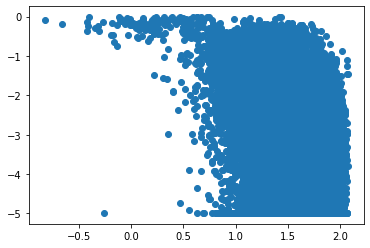

In [64]:
plt.scatter(np.log10(dists),wt_conn_min_log)

In [42]:
np.where(wt_conn_min_log == -5)[0].shape


(112574,)

In [43]:
np.where(wt_conn_min_log > -5)[0].shape

(3553,)

In [65]:
oos_ic_majors.shape

(621,)

In [62]:
wt_conn_sum = np.load('/Users/samsonkoelle/wt_conn_sum.npy')

In [63]:
maj_str  = np.load('/Users/samsonkoelle/sum_maj.npy')

In [64]:
distances = np.load('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/paper/getinfo/distances_summary_summary.npy')

In [65]:
ids = np.where(wt_conn_sum.sum(axis = 1) > 0)[0]

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [67]:
wt_conn_sum[np.where(wt_conn_sum < 1e-6)] = 1e-6

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [68]:
wt_conn_min_log = np.log(wt_conn_sum)

In [69]:
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]

In [70]:
maj_str[ids]


array([ 315,  315,  315,  315,  315,  315,  315,  315,  315,  315,  315,
        315,  315,  315,  315,  315,  315,  315,  315,  315,  315,  315,
        315,  315,  315,  315,  315,  315,  315,  315,  315,  315,  315,
        315,  315,  698,  698,  698,  698,  698, 1089, 1089, 1089, 1089,
       1089, 1089, 1089, 1089,  703,  477,  477,  477,  477,  477,  477,
        803,  803,  803,  549,  549,  549,  549,  549,  549,  549,  549,
        549, 1097, 1097, 1097, 1097,  313,  313,  313,  313,  313,  313,
        771,  771,  771,  771,  354,  354,  354,  354,  354,  354,  354,
        354,  354,  354,  354,  512,  512,  512,  512,  512,  512,  512,
        512,  512])

0
1
2
3
4
5
6
7
8
9
10


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


11


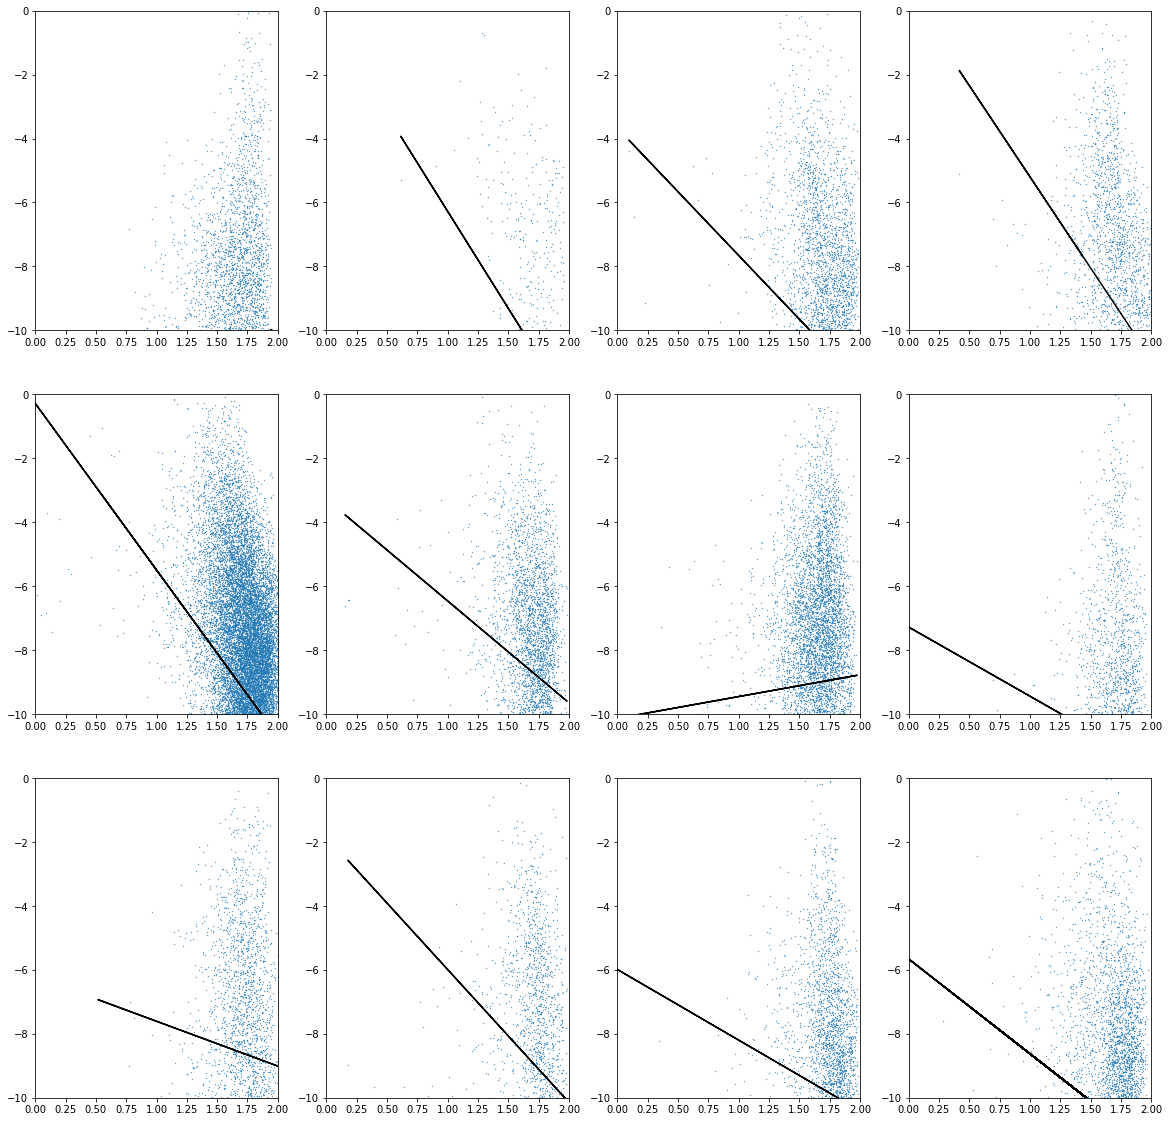

In [74]:
fig, axes = plt.subplots(3,4,figsize = (20,20))
for m in range(12):
    
    inds = np.where(maj_str[ids] == major_structure_ids[m])[0]
    if len(inds) > 0:
        print(m)
        xs = np.log10(np.asarray(dists)[ids][inds])
        ys = wt_conn_min_log[ids][inds]
        xs = np.reshape(xs, xs.shape[0]*xs.shape[1])
        ys = np.reshape(ys, ys.shape[0]*ys.shape[1])
        kepinds = np.where(np.isinf(xs))[0]
        #print(kepinds)
        xs = xs[np.setdiff1d(list(range(len(xs))),kepinds)]
        ys = ys[np.setdiff1d(list(range(len(ys))),kepinds)]
        lr = LinearRegression()
        lr.fit(np.expand_dims(xs,1),ys)
        axes[math.floor(m / 4), m%4].scatter(xs,ys, s = .1)
        yp = lr.intercept_ + np.expand_dims(xs,1) * lr.coef_
        axes[math.floor(m / 4), m%4].plot(xs, yp,color='k')
        axes[math.floor(m / 4), m%4].set_xlim(0,2)
        axes[math.floor(m / 4), m%4].set_ylim(-10,0)

In [51]:
m = 4
inds = np.where(maj_str[ids] == major_structure_ids[m])[0]

In [55]:
ids

array([ 43,  45,  48,  53,  54,  56,  57,  62,  65,  68,  76,  77,  80,
        81,  89,  90,  94,  97, 100, 103, 113, 116, 121, 123, 131, 134,
       151, 171, 175, 183, 188, 198, 201, 233, 238, 244, 248, 254, 256,
       260, 261, 269, 272, 278, 281, 286, 287, 290, 296, 297, 300, 303,
       304, 305, 307, 309, 310])

In [54]:
maj_str[ids]

array([ 698,  698,  698,  698, 1089, 1089, 1089, 1089, 1089, 1089,  477,
        477,  477,  477,  477,  803,  803,  803,  549,  549,  549,  549,
        549,  549,  549,  549, 1097, 1097, 1097, 1097,  313,  313,  313,
        771,  771,  771,  771,  354,  354,  354,  354,  354,  354,  354,
        354,  354,  354,  354,  512,  512,  512,  512,  512,  512,  512,
        512,  512])

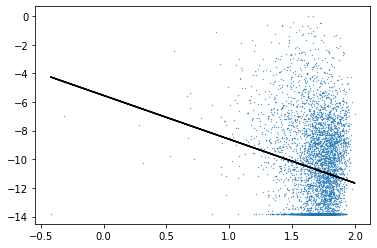

In [48]:
m = 4
inds = np.where(maj_str[ids] == major_structure_ids[m])[0]
if len(inds) > 0:
    xs = np.log10(np.asarray(dists)[ids][inds])
    ys = wt_conn_min_log[ids][inds]
    xs = np.reshape(xs, xs.shape[0]*xs.shape[1])
    ys = np.reshape(ys, ys.shape[0]*ys.shape[1])
    kepinds = np.where(np.isinf(xs))[0]
    #print(kepinds)
    xs = xs[np.setdiff1d(list(range(len(xs))),kepinds)]
    ys = ys[np.setdiff1d(list(range(len(ys))),kepinds)]
    lr = LinearRegression()
    lr.fit(np.expand_dims(xs,1),ys)
plt.scatter(xs,ys, s = .1)
    #axes[math.floor(m / 4), m%4].scatter(xs,ys, s = .1)
yp = lr.intercept_ + np.expand_dims(xs,1) * lr.coef_
plt.plot(xs, yp, color = 'k')
    #axes[math.floor(m / 4), m%4].plot(xs, yp,color='k')

In [46]:
ys.shape

(4968,)

In [30]:
xs

array([], dtype=float64)

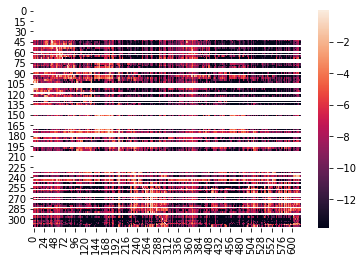

In [28]:
sns.heatmap(wt_conn_min_log)

In [21]:
maj_str.shape

(313,)

In [29]:
kepinds

array([], dtype=int64)

In [31]:
inds

array([], dtype=int64)